# ENVR 453: Groundwater Hydrology

## Uncertainty Quantification

Load the necessary packages

In [25]:
!pip install dataretrieval
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

Let's look again at data from the USGS site located on the Haw River in Haw River, NC.

Here is a link to the web interface: https://waterdata.usgs.gov/monitoring-location/02096500/#parameterCode=00065&period=P7D

In [26]:
### Grab the streamflow data and plot

### HAW RIVER AT HAW RIVER, NC
HRSiteID = '02096500'

### Dates for Start and End of Data
startDate = '2023-08-01'
endDate = '2023-08-20'

### Type of Data
### See https://github.com/DOI-USGS/dataretrieval-python for options
dataType = 'stat'

### Streamflow
param = '00060'

### Want Annual Statistics
reportType='annual'

### Grab Rain Data (inches)
HRRiverData = nwis.get_record(sites=HRSiteID, service=dataType,parameterCd=param,reportType='annual')

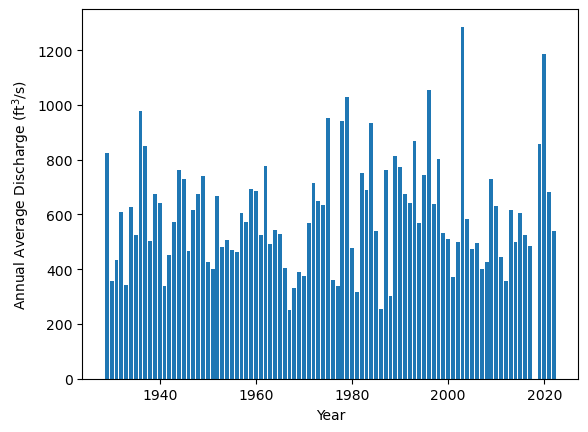

In [27]:
### Plot the Annual Average Streamflow Data for Haw River
fig, ax = plt.subplots()
plt.bar(HRRiverData['year_nu'],HRRiverData['mean_va'])
plt.xlabel('Year')
plt.ylabel('Annual Average Discharge (ft$^3$/s)')
plt.show()

## Generate Some Statistics of the Average Annual Streamflow

In [28]:
meanStreamFlow = np.mean(HRRiverData['mean_va'])
stdevStreamFlow = np.std(HRRiverData['mean_va'])
print(f'Mean Streamflow: {meanStreamFlow} ft^3/s')
print(f'Streamflow standard deviation: {stdevStreamFlow} ft^3/s')

Mean Streamflow: 600.6247311827957 ft^3/s
Streamflow standard deviation: 202.47654299606515 ft^3/s


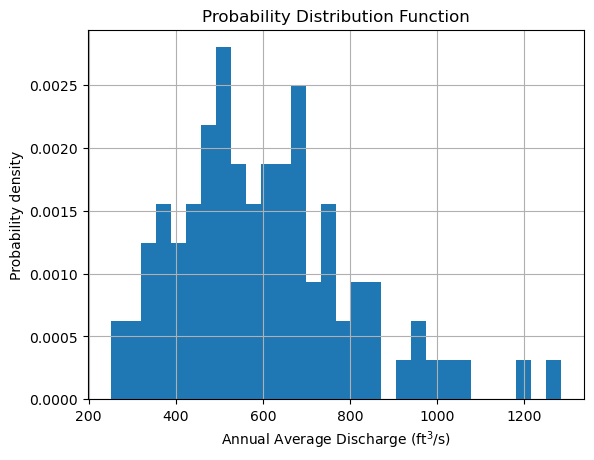

In [29]:
### Plot a histogram of the annual average streamflow data for Haw River
fig, ax = plt.subplots()
num_bins = 30
n, bins, patches = ax.hist(HRRiverData['mean_va'], num_bins, density=True)
ax.set_xlabel('Annual Average Discharge (ft$^3$/s)')
ax.set_ylabel('Probability density')
plt.title("Probability Distribution Function")
ax.grid(True)
plt.show()

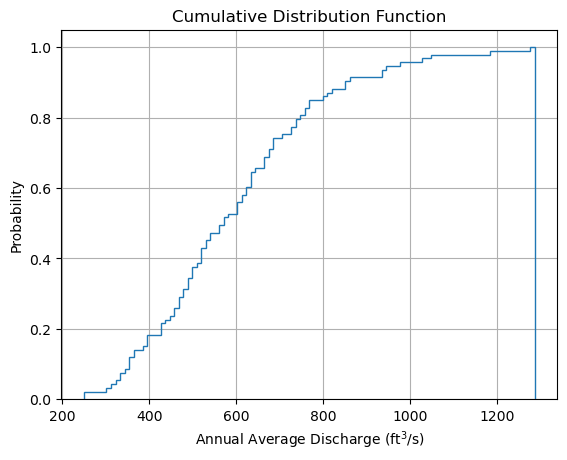

In [30]:
### Plot a histogram of the annual average streamflow data for Haw River
fig, ax = plt.subplots()
num_bins = 100
n, bins, patches = ax.hist(HRRiverData['mean_va'], num_bins, histtype='step', cumulative=True, density=True)
ax.set_xlabel('Annual Average Discharge (ft$^3$/s)')
ax.set_ylabel('Probability')
plt.title("Cumulative Distribution Function")
ax.grid(True)
plt.show()

## Let's assume a lognormal distribution for streamflow data

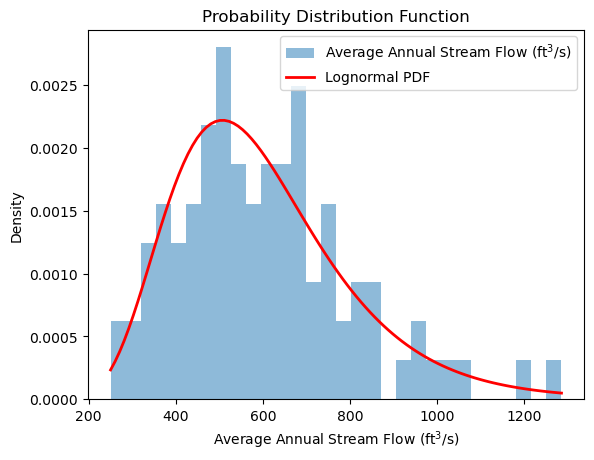

In [31]:
data = HRRiverData['mean_va']
shape, loc, scale = stats.lognorm.fit(data,floc=np.log(meanStreamFlow))

### Generate a pdf from the fit model
x = np.linspace(min(data), max(data), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

### Plot pdf
plt.hist(data, bins=30, density=True, alpha=0.5, label='Average Annual Stream Flow (ft$^3$/s)')
plt.plot(x, pdf, 'r-', lw=2, label='Lognormal PDF')
plt.ylabel('Density')
plt.xlabel('Average Annual Stream Flow (ft$^3$/s)')
plt.title("Probability Distribution Function")
plt.legend()
plt.show()

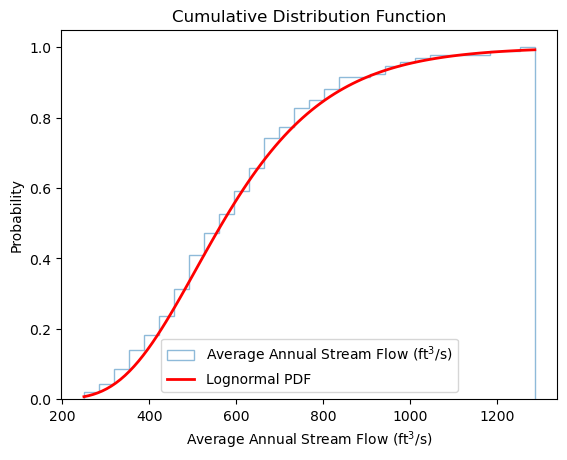

In [32]:
## Plot CDF
cdf = stats.lognorm.cdf(x, shape, loc, scale)
plt.hist(data, bins=30, density=True, alpha=0.5, label='Average Annual Stream Flow (ft$^3$/s)',histtype='step', cumulative=True)
plt.plot(x, cdf, 'r-', lw=2, label='Lognormal PDF')
plt.ylabel('Probability')
plt.xlabel('Average Annual Stream Flow (ft$^3$/s)')
plt.title("Cumulative Distribution Function")
plt.legend()
plt.show()

In [33]:
### Check the fit with Kolmogrov-Smirnov Test
kstest_result = stats.kstest(data, 'lognorm', args=(shape, loc, scale))
print(kstest_result)

KstestResult(statistic=0.0486448641836823, pvalue=0.9727552320910259, statistic_location=605.3, statistic_sign=-1)


# How do we incorporate Uncertainty into the Water Balance? 

## Monte Carlo Simulation
Sample parameter from given distribution and see how model predictions vary.

Consider our previous water balance calculation:

Area = 10 acres = 435,600 ft^2 \
River_in = 25 ft^3/s \
River_out = 30 ft^3/s \
Rain = 0.5 in/hr

In [72]:
## Model Parameters (and unit conversions)
secondsToHour = 3600
inchToFoot = 1./12.
acresToFeet = 43560. 

riverIn = 25. * secondsToHour # 25 ft^3/s to ft^3/hour
riverOut = 30. * secondsToHour # 30 ft^3/s to ft^3/hour

rainArea = 10. * acresToFeet # acres to ft^2
Rain = 0.5 * inchToFoot # 0.5 in/hr to ft/hr
rainIn = rainArea * Rain # ft^3/hr


## Gather Inflows and Outflow
Qin = riverIn + rainIn
Qout = riverOut

#Create Model for Water Balance
dVdt = Qin - Qout
print(f'Change in Volume is {dVdt} ft^3/s')

Change in Volume is 150.0 ft^3/s


## What if the Area where it rained was a random variable?
We Need a probability distribution function to sample from which is determined from existing measurements. \

Let's assume the rain area is normally distributed with a mean of 8 acres and a standard deviation of 0.5 acres.

In [98]:
# Set the Statistics
rainAreaMean = 10 # Acres
rainAreaSTD = 0.1 # Acres

# Draw N samples from the distribution 
N = 10000
rainAreaSample = np.random.normal(rainAreaMean,rainAreaSTD,size = N)

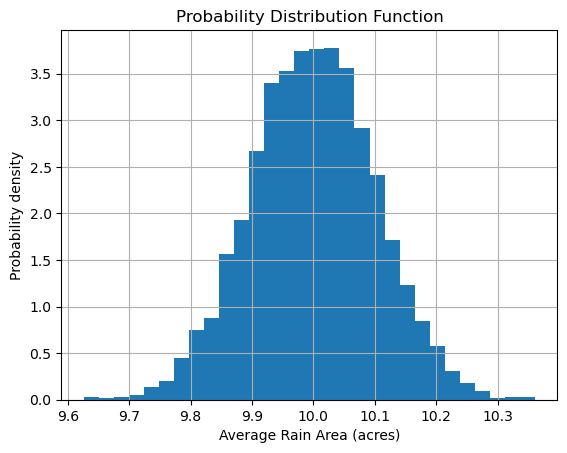

In [99]:
# Lets Look at the Sample Distribution
fig, ax = plt.subplots()
num_bins = 30
n, bins, patches = ax.hist(rainAreaSample, num_bins, density=True)
ax.set_xlabel('Average Rain Area (acres)')
ax.set_ylabel('Probability density')
plt.title("Probability Distribution Function")
ax.grid(True)
plt.show()

In [100]:
# Perform the water balance with the sampled rain area

# Convert acres to feet and get rain In 
rainArea = rainAreaSample * acresToFeet # acres to ft^2
rainIn = rainArea * Rain # ft^3/hr

## Gather Inflows and Outflow
Qin = riverIn + rainIn
Qout = riverOut

#Create Model for Water Balance
dVdt = Qin - Qout

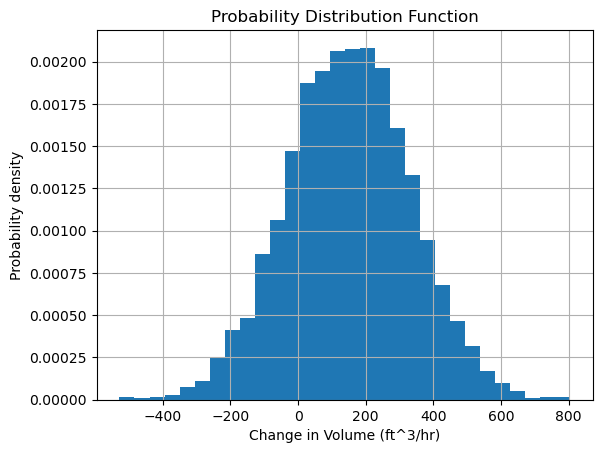

In [101]:
# Lets Look at the Resulting PDF
fig, ax = plt.subplots()
num_bins = 30
n, bins, patches = ax.hist(dVdt, num_bins, density=True)
ax.set_xlabel('Change in Volume (ft^3/hr)')
ax.set_ylabel('Probability density')
plt.title("Probability Distribution Function")
ax.grid(True)
plt.show()

In [102]:
# Lets Look at the Resulting CDF
fig, ax = plt.subplots()
num_bins = 30
n, bins, patches = ax.hist(dVdt, num_bins, histtype='step', cumulative=True, density=True)
ax.set_xlabel('Annual Average Discharge (ft$^3$/s)')
ax.set_ylabel('Probability')
plt.title("Cumulative Distribution Function")
ax.grid(True)
plt.show()

Mean : 150.00662940337727 ft^3/s
Standard deviation: 178.8440478103159 ft^3/s


In [ ]:
# Statistics for Change in Volume 
meandVdt = np.mean(dVdt)
stdVdt = np.std(dVdt)
print(f'Mean : {meandVdt} ft^3/s')
print(f'Standard deviation: {stdevsVdt} ft^3/s')